In [1]:
from datasets import load_dataset, get_dataset_split_names, Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from ultralytics import YOLO

/home/chateaux/OpenClassrooms/Projet8/veille technique/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Méthodes utiles

In [2]:
def coco_to_yolo(bbox, img_w, img_h):
    """
    Method that transforms any bbox in coc format to yolo format so that 
    it can be used as input to a YOLO model
    """
    x, y, w, h = bbox
    cx = (x + w / 2) / img_w
    cy = (y + h / 2) / img_h
    w /= img_w
    h /= img_h
    return cx, cy, w, h

In [56]:
# Inspect dataset splits
get_dataset_split_names("benjamintli/SKU110k")

['train', 'validation', 'test']

In [57]:
dataset = load_dataset("benjamintli/SKU110k")
# dataset = dataset.cast_column("image", Image())

In [58]:
print(dataset['train'])

Dataset({
    features: ['image', 'objects'],
    num_rows: 8219
})


In [59]:
sample = dataset["train"][0] 
print(type(sample["image"]))  # PIL.Image.Image
print(sample["objects"].keys())

<class 'PIL.JpegImagePlugin.JpegImageFile'>
dict_keys(['bbox', 'category'])


In [60]:
sample["objects"]['bbox'][0]

[208.0, 537.0, 214.0, 277.0]

Note : ne fonctionne que si pillow est installé, si ce n'était pas le cas, il faut réinitialiser l'environnement, lui ajouter pillow et relancer tout le notebook

### Vérification visuelle du format des bbox

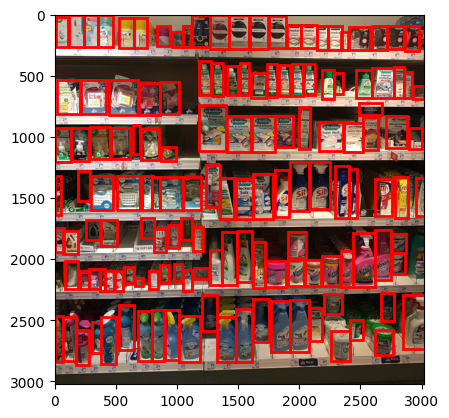

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(sample["image"])

for bbox in sample["objects"]['bbox']:

    x, y, w, h = bbox
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.show()


Les bbox sont bien au format coco : [x_min, y_min, width, height]

# Enregistrer les données au format YOLO

In [62]:
type(dataset['train'][0]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [63]:
import os

def convert_coco_to_yolo(dataset, output_dir):
    for split in dataset.keys():
        output_image_dir = f"{output_dir}/images/{split}/"
        if not os.path.isdir(output_image_dir):
            os.makedirs(output_image_dir)
        output_labels_dir = f"{output_dir}/labels/{split}/"
        if not os.path.isdir(output_labels_dir):
            os.makedirs(output_labels_dir)
        for idx_im, image in enumerate(dataset[split]):
            im_width, im_height = image['image'].size
            image['image'].save(os.path.join(output_image_dir, f"image_{idx_im}.jpeg"))
            output_label_file = os.path.join(output_labels_dir, f"image_{idx_im}.txt")
            with open(output_label_file, 'w') as f:
                for idx_box, bbox in enumerate(image['objects']['bbox']):
                    category_id = image['objects']['category'][idx_box]
                    #transform and normalize
                    x_min, y_min, width, height = bbox
                    x_center = (x_min + width / 2) / im_width
                    y_center = (y_min + height / 2) / im_height
                    width /= im_width
                    height /= im_height
                    f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

In [64]:
convert_coco_to_yolo(dataset, 'data_yolo')

### Vérification visuelle de la transformation en YOLO

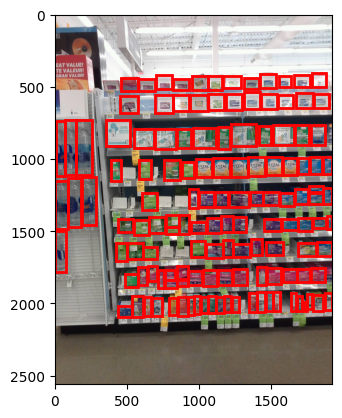

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = Image.open("data_yolo/images/test/image_1.jpeg")
w, h = img.size
fig, ax = plt.subplots(1)
ax.imshow(img)

# lines_list = []
with open("data_yolo/labels/test/image_1.txt") as f:
    lines_list = [line.rstrip('\n').split() for line in f]

for line in lines_list: 
    cls, cx, cy, bw, bh = map(float, line)
    x = (cx - bw / 2) * w
    y = (cy - bh / 2) * h
    bw *= w
    bh *= h
    ax.add_patch(
        patches.Rectangle((x, y), bw, bh, edgecolor="red", facecolor="none", linewidth=2)
    )
plt.show()


Les rectangles encadrent bien les produits, la conversion est correcte.

In [16]:
model = YOLO("yolov3u.pt")

In [17]:
# Display model information (optional)
model.info()

YOLOv3 summary: 180 layers, 103,754,144 parameters, 0 gradients, 283.3 GFLOPs


(180, 103754144, 0, 283.3201664)

In [6]:
# # Train the model on the COCO8 example dataset for 100 epochs
# results = model.train(data="dataset_config.yaml", device=[-1, -1])



In [21]:
metrics = model.val(data="dataset_config.yaml", split="test")

Ultralytics 8.4.9 🚀 Python-3.13.5 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 311.5±111.6 MB/s, size: 957.6 KB)
val: Scanning /home/chateaux/OpenClassrooms/Projet8/veille technique/data_yolo/labels/test... 2936 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2936/2936 553.6it/s 5.3s0.1s
val: New cache created: /home/chateaux/OpenClassrooms/Projet8/veille technique/data_yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 184/184 1.0it/s 2:570.8ss
                   all       2936     431546      0.145     0.0028     0.0726     0.0322
                person       2936     431546      0.145     0.0028     0.0726     0.0322
Speed: 0.6ms preprocess, 49.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /home/chateaux/OpenClassrooms/Projet8/veille technique/runs/detect/val2


In [18]:
# Run inference with the YOLOv3u model on the 'bus.jpg' image
results = model("data_yolo/images/test/image_1.jpeg")


image 1/1 /home/chateaux/OpenClassrooms/Projet8/veille technique/data_yolo/images/test/image_1.jpeg: 640x480 6 bottles, 1 refrigerator, 41.7ms
Speed: 2.3ms preprocess, 41.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Ajouter la visualisation des boites de détection + résultats de métriques

In [ ]:
# Run batched inference on a list of images
results = model("data_yolo/images/test/image_1.jpeg")  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


image 1/1 /home/chateaux/OpenClassrooms/Projet8/veille technique/data_yolo/images/test/image_1.jpeg: 640x480 6 bottles, 1 refrigerator, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


[24647:24647:0202/214016.330271:ERROR:dbus/object_proxy.cc:573] Failed to call method: org.freedesktop.DBus.Properties.GetAll: object_path= /org/freedesktop/UPower/devices/DisplayDevice: org.freedesktop.DBus.Error.ServiceUnknown: The name org.freedesktop.UPower was not provided by any .service files
[24783:7:0202/214016.333649:ERROR:gpu/ipc/client/command_buffer_proxy_impl.cc:122] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
Created TensorFlow Lite XNNPACK delegate for CPU.
[24647:24677:0202/214019.451900:ERROR:google_apis/gcm/engine/registration_request.cc:292] Registration response error message: DEPRECATED_ENDPOINT
[24647:24677:0202/214046.410531:ERROR:google_apis/gcm/engine/registration_request.cc:292] Registration response error message: DEPRECATED_ENDPOINT


# RF DTR